100%|███████████████████████████████████████████| 40/40 [00:12<00:00,  3.12it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


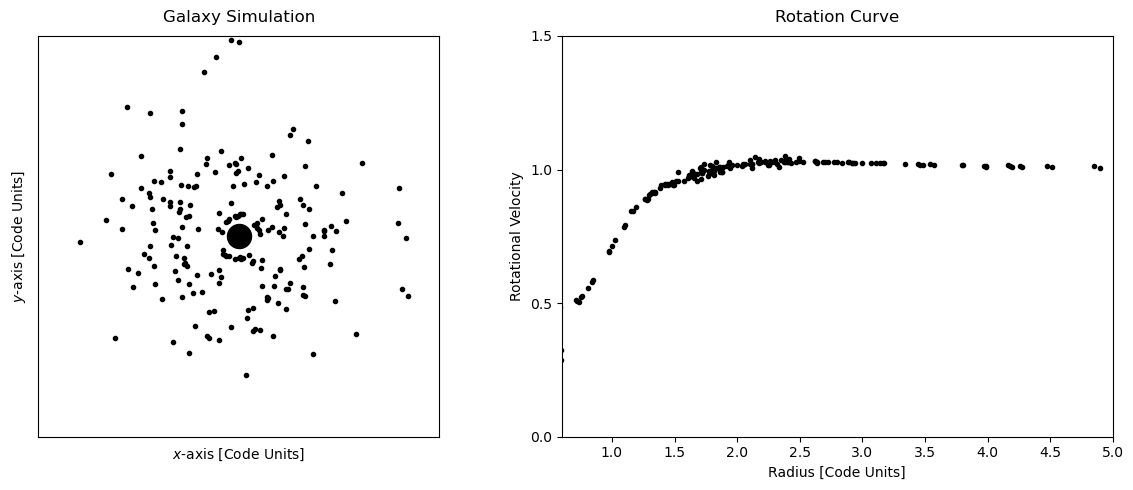

In [1]:
import sys
!{sys.executable} -m pip install celluloid
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera
from tqdm import tqdm
from scipy.stats import expon

def convert_polar_to_cart(θ, r):
    """
    Helper Function for converting from 
    polar to cartesian coordinates.
    """
    x = r * np.cos(θ)
    y = r * np.sin(θ)
    return np.array([x, y])

def gaussian(x, mu, sig):
    """
    Helper function to create a Gaussian curve.
    """
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


class Star:
    """
    Object class to make Star objects.
    """
    def __init__(self, position, velocity, mass):
        """
        Constructor method for Star objects.
        
        position: [1d array of len 2] - np.array([float, float])
        velocity: [1d array of len 2] - np.array([float, float])
        mass: [float] 
        force: [1d array of len 2] - np.array([float, float]) (initially zero)
        
        """
        self.position = position
        self.velocity = velocity 
        self.mass = mass 
        self.force = 0
        
    def calc_grav_force(self, other_star):
        """
        Method to compute gravity between two Star objects. 
        """
        G = 6.67e-11 # N m^2 / kg^2
        
        #calculate Force Magnitude
        dr_vec = other_star.position - self.position
        dr = np.linalg.norm(dr_vec)
        F = G * (self.mass * other_star.mass) / (dr)**2   
        
        #condition to "handle" collision instabilities  
        if dr < 5e-2: 
            F = 0
            
        #calculate Force Vector    
        F_hat = dr_vec / dr
        self.force += F * F_hat
        
    def calc_acceleration(self):
        """
        Method for computing the acceleration of a Star object.
        """
        #using Newton's 2nd Law
        self.acceleration = self.force / self.mass
        
y_hat = np.array([0.,1.])
x_hat = np.array([1.,0.])

def initialize_galaxy(R_inner, R_outer):
    """
    Initialize the galaxy by populating it with stars. We set all stars to have a uniform mass
    and follow a characteristic dark matter velocity curve. We use an approximate velocity curve
    that is not physically true but to orders of magnitude it does the trick. We populate the galaxy
    with stars following an exponential distribution as there are more stars in the galactic bulge
    than the rest of the galaxy. 
    """
    mass_of_each_star = 1e6

    #initialize coordinates of stars (working in polar coordinates)
    rs_g = expon.rvs(scale=1.2,loc=R_inner,size=N_stars)
    θs_g = np.random.rand(N_stars) * 360
    polar_coords = np.array([θs_g, rs_g])

    #create list of star objects created from the coordinates
    stars = []
    for i in range(N_stars):
        θ, r = polar_coords[:,i]
        cart_pos = convert_polar_to_cart(θ, r) #convert to cartesian
        cart_v_0 = np.zeros(2) #initial velocity of 0
        stars.append(Star(cart_pos, cart_v_0, mass_of_each_star))
        
    #create a central black hole x1e3 more massive than the other stars
    BH = Star(np.zeros(2), cart_v_0, 1e3 * mass_of_each_star)
    return stars, BH

def update_physics_gravity(stars, BH):
    """
    Function for calculating the effects of gravity on 
    the motion of the N-bodies. We use standard Newtonian laws
    of gravity with an O(N^2) implementation of force calculations.
    """
    #calculate the total gravity acting on an object
    for i in range(N_stars):
        stars[i].calc_grav_force(BH)
        for j in range(N_stars):
            if i != j: 
                stars[i].calc_grav_force(stars[j])
        
                
    #update the stars based on the physics
    for i in range(N_stars):
        stars[i].calc_acceleration()
        dv = stars[i].acceleration * dt
        stars[i].velocity = stars[i].velocity + dv
        dp = stars[i].velocity * dt
        stars[i].position = stars[i].position + dp
        
        
def update_physics_rotation_curve(stars):
    """
    Function to calculate the contribution to the motion of stars 
    from DM. We do this by simply just forcing the velocity curve to follow
    a typical DM rotation curve. This means the velocity is roughly constant with 
    respect to radius except when close to the center. 
    """
    v_0 = 1
    #update the stars based on Constant DM rotational curve
    for i in range(N_stars):
        x, y = stars[i].position
        r = np.sqrt(x**2 + y**2)
        θ_hat = (-y*x_hat + x*y_hat)/ r
        v_θ = v_0/(10*gaussian(r, 0, 0.4) + 1)
        v = θ_hat * v_θ
        stars[i].velocity = v
        dp = stars[i].velocity * dt
        stars[i].position = stars[i].position + dp
                
        
def draw(axes, stars, BH, camera):
    """
    Function for plotting/drawing the motion of the particles with each frame.
    This function takes in an axes object and modifies it.
    """
    #collect all x,y coordinates from all the stars
    xs, ys, rs, vs = [], [], [], []
    for i in range(N_stars):
        x, y = stars[i].position
        r = np.sqrt(x**2 + y**2)
        θ_hat = (-y*x_hat + x*y_hat)/ r
        v_θ = np.abs(np.dot(θ_hat, stars[i].velocity))
        xs.append(x); ys.append(y)
        rs.append(r); vs.append(v_θ)
        
    xs, ys, rs, vs = np.array(xs), np.array(ys), np.array(rs), np.array(vs)
        
    #plot the positions of the stars and the Black Hole
    axes[0].scatter(BH.position[0],BH.position[1], s=300, facecolor="black", edgecolor="black")
    axes[0].scatter(xs, ys, color="black", marker=".")
    
    axes[1].scatter(rs, vs, color="black", marker=".")
    camera.snap()
    
def main():
    """
    Main loop hosted within this function. This runs the entire simulation.
    """

    #setup the galaxy
    galaxy, BH = initialize_galaxy(R_inner, R_outer)

    #create the figure
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    #left panel (positions)
    axes[0].set_xlim(-R_outer, R_outer); axes[0].set_ylim(-R_outer, R_outer)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    axes[0].set_xticklabels([]); axes[0].set_yticklabels([])
    axes[0].set_aspect('equal')
    axes[0].set_title("Galaxy Simulation", pad = 10)
    axes[0].set_xlabel("$x$-axis [Code Units]")
    axes[0].set_ylabel("$y$-axis [Code Units]")

    #left panel (positions)
    axes[1].set_xlim(R_inner, R_outer)
    axes[1].set_title("Rotation Curve", pad = 10)
    axes[1].set_xlabel("Radius [Code Units]")
    axes[1].set_ylabel("Rotational Velocity")
    axes[1].set_yticks([0.0, 0.5, 1.0, 1.5])
    axes[1].set_ylim(0, 1.5)
    plt.tight_layout()
    camera = Camera(fig)

    #Main Loop for Simulation!
    for frame in tqdm(range(N_frames)):
        draw(axes, galaxy, BH, camera)
        update_physics_rotation_curve(galaxy)
        update_physics_gravity(galaxy, BH)

    animation = camera.animate(blit=True)

    #save animation
    animation.save('galaxy2.gif', writer = 'imagemagick')
    
#Simulation Parameters
N_frames = 40 #number of frames for animation
N_stars = 200 #number of stars to use in our N-body sim
dt = 0.1 #time step size
R_inner, R_outer = 0.6, 5 #inner and outer bounds for stars to be formed in
    
if __name__ == "__main__": main()  